In [2]:
import os
import cv2
import yt_dlp
import random
import math
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

 
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback

In [3]:
seed_cons=27
np.random.seed(seed_cons)
tf.random.set_seed(seed_cons)
random.seed(seed_cons)

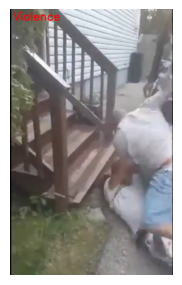

In [7]:
#to make the image and also here we going to see the first frame of each video
plt.figure(figsize=(20, 20))
#getting the classnames from the dataset
class_names = os.listdir('dataset')
#selecting 20 random classes from the dataset, it is optional
random_range=random.sample(range(len(class_names)), 1) 
#after selecting the classes, we are going to read the first frame of the video in each selected class and video in randomly taken
#and show it in the matplotlib
for counter,random_index in enumerate(random_range,1):
    sel_class = class_names[random_index]
    video_list = os.listdir(os.path.join('dataset', sel_class))
    sel_video=random.choice(video_list)
    video_read=cv2.VideoCapture(os.path.join('dataset', sel_class, sel_video))
    _,bgr =video_read.read()
    video_read.release()
    rgb= cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb,sel_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    plt.subplot(5, 4, counter) # here counter used to plt the img in figure basically mltiple images in single figure
    plt.imshow(rgb)
    plt.axis('off')

In [8]:
# we are going to use 64x64 image size, it is optional you can change
img_height, img_width = 64,64
# we are going to use 20 frames from each video because in the LSTM we need a sequence of node for computation if large means more time and computation
#and also take more time and memory to train the model and inference 
seq_len=20
DATASET_PATH = 'dataset'
# You can change the CLASSES variable to include any classes you want to work with
CLASSES = ["Normal","Violence"]


In [9]:
# this function is uded to extract the selected frames from the overall video instead of taking the entire video
# here 20 frames will be extracted from the every video based on the seq_len and also here we processing the like resizing and normalizing the frames
def frames_extractor(video_path):
    frame_list = []
    video_reader= cv2.VideoCapture(video_path)
    #it helps to get the total number of frames in the video
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # it helps to find the no of frames to be skipped for getting the 20 frames equally from the overall video
    skip_frames = max(int(frame_count / seq_len), 1)
    for i in range(seq_len):
        # here opencv reads from the starting frame by default but here we setting the start frame as per the loop and skips the unwanted frames
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames)
        ret, frame = video_reader.read()
        if not ret:
            break
        resize_frame = cv2.resize(frame, (img_height, img_width))
        normalized_frame = resize_frame / 255.0
        frame_list.append(normalized_frame)
    video_reader.release()
    return frame_list 

In [10]:
# to create the dataset from the video files in the dataset
def create_dataset():
  feature=[] # to store the extracted frames details
  label=[] # to store the respectve class values
  video_path=[]  # to store the video file paths
  # getting into dataset by looping the classes
  for class_index, class_name in enumerate(CLASSES):
      print(f"Extracting frames from class: {class_name}")
      class_path = os.path.join(DATASET_PATH, class_name)
      video_files = os.listdir(class_path) # getting all the video of specific class
      # getting the all the video to be processed and extracting the frames
      for video_file in video_files:
          video_full_path = os.path.join(class_path, video_file)
          frames = frames_extractor(video_full_path) #func to extract the frames
          if len(frames) == seq_len: #checking all works fine
              feature.append(frames)
              label.append(class_index)
              video_path.append(video_full_path)
  feature=np.array(feature) #cvt from python list to numpy array
  label=np.array(label) #cvt from python list to numpy array
  return feature, label, video_path


In [38]:
# here we create the dataset of extract frames
Feature, Labels, Video_path=create_dataset()
one_hot_labels = to_categorical(Labels) #hot encoding the label means cvt the cls labels from int like 0,1,2,3 to some like [1,0,0,0] for 0 class and [0,1,0,0] for 1 class and so on 
#where the not get confused were if twice of 1 will be 2 it will be unique for each class


Extracting frames from class: Normal
Extracting frames from class: Violence


In [13]:
data = np.load("video_dataset.npz", allow_pickle=True)
Feature = data["feature"]
Labels = data["labels"]
Video_path = data["video_path"]
one_hot_labels = to_categorical(Labels)

In [14]:
# here we split the dataset into train and test sets 75% Train and 25% Test
feature_train, feaure_test, label_train, label_test = train_test_split(Feature, one_hot_labels, test_size=0.25, shuffle=True, random_state=seed_cons)

In [40]:
np.savez("video_dataset.npz", feature=Feature, labels=Labels, video_path=Video_path)

In [15]:
def create_convlstm_model():
    model=Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (seq_len, img_height, img_width, 3)))

    model.add(TimeDistributed(MaxPooling2D((2, 2)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))

    model.add(Dense(len(CLASSES), activation = 'softmax'))

    model.summary()
    return model

In [16]:
# creating the ConvLSTM model
convlstm_model = create_convlstm_model()
print("Model created successfully!")

c:\Users\mohes\Desktop\norag\venv\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 64) │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 8, 8, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 4, 4, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 4, 4, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 4, 4, 128)  │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 2, 2, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 2, 2, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 20, 2, 2, 128)  │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 20, 1, 1, 128)  │             

 Total params: 487,234 (1.86 MB)

 Trainable params: 487,234 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Model created successfully!


In [17]:
# earlystopping is used stop the train when it reaches the certain condition here the val_loss not decreases(mode='min') for 10 epochs means stop
early_stopping = EarlyStopping(monitor="val_loss", patience=15, mode='min', restore_best_weights=True)
# here the categorical crossentropy loss is used because this is a multi-class classification
convlstm_model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy'])
# here we train the model with the training data and also validation split is used to validate the model with 20% of the training data
convlstm_model_history = convlstm_model.fit(x=feature_train, y=label_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 247s 333ms/step - accuracy: 0.4929 - loss: 0.6985 - val_accuracy: 0.4844 - val_loss: 0.6932
Epoch 2/50
 97/673 ━━━━━━━━━━━━━━━━━━━━ 4:47 499ms/step - accuracy: 0.4623 - loss: 0.6957

KeyboardInterrupt: 

In [15]:
# evaluate the model
model_eval=convlstm_model.evaluate(feaure_test,label_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7705 - loss: 0.6576


In [16]:
# here getting the model eval data
model_eval_loss,model_eval_acc=model_eval
# mentioning how the format of date and time to be looked
date_time_format='%Y_%m_%d_%H_%M_%S'
# getting the current date and time
current_dt=dt.datetime.now().strftime(date_time_format)
# saving the model name
model_name=f"convLSTM_date_time_{current_dt}_loss_{model_eval_loss}_acc_{model_eval_acc}.h5"
convlstm_model.save(model_name)

In [17]:
def plot_metrics(model_train_history,metrics1,metrics2,name):
    metric_val1=model_train_history.history[metrics1]
    metric_val2=model_train_history.history[metrics2]
    epochs = range(len(metric_val1))
    plt.plot(epochs, metric_val1, 'blue', label=metrics1)
    plt.plot(epochs, metric_val2, 'red', label=metrics2)
    plt.title(str(name))
    plt.legend()

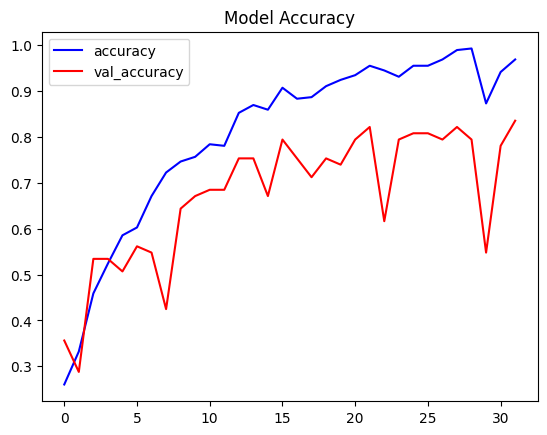

In [18]:
plot_metrics(convlstm_model_history, 'accuracy', 'val_accuracy', 'Model Accuracy')

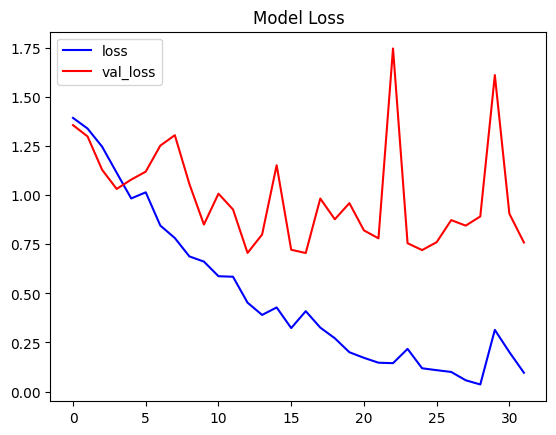

In [19]:
plot_metrics(convlstm_model_history, 'loss', 'val_loss', 'Model Loss')

In [20]:
def youtube_video_download(output_dir, video_url):
    ydl_opts = {
        'outtmpl': f'{output_dir}/%(title)s.%(ext)s',
        'format': 'mp4[height<=720]+bestaudio/best[ext=mp4]',  
        'merge_output_format': 'mp4',
        'prefer_ffmpeg': False, 
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=True)
        return info.get('title', None)

In [21]:
os.makedirs('downloaded_videos', exist_ok=True)
video_title = youtube_video_download('downloaded_videos', 'https://youtube.com/shorts/9tDoyzL9uwQ?si=5O5SjK6nt3jwwpk-')
video_path = f'downloaded_videos/{video_title}.mp4'

[youtube] Extracting URL: https://youtube.com/shorts/9tDoyzL9uwQ?si=5O5SjK6nt3jwwpk-
[youtube] 9tDoyzL9uwQ: Downloading webpage
[youtube] 9tDoyzL9uwQ: Downloading tv client config
[youtube] 9tDoyzL9uwQ: Downloading tv player API JSON
[youtube] 9tDoyzL9uwQ: Downloading ios player API JSON
[youtube] 9tDoyzL9uwQ: Downloading m3u8 information
[info] Testing format 605
[info] Testing format 234
[info] 9tDoyzL9uwQ: Downloading 1 format(s): 605+234
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 3
[download] Destination: downloaded_videos\Taichi 4 basic moves.f605.mp4
[download] 100% of  367.34KiB in 00:00:00 at 1.56MiB/s                 
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 3
[download] Destination: downloaded_videos\Taichi 4 basic moves.f234.mp4
[download] 100% of  257.73KiB in 00:00:00 at 1.73MiB/s                 
[Merger] Merging formats into "downloaded_videos\Taichi 4 basic moves.mp4"
Deleting original file downloaded_videos\Taichi 4 bas

In [22]:
def predict_video(video_path,output_file_path,seq_len):
    video_reader = cv2.VideoCapture(video_path)
    org_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    org_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M','P','4','V'), video_reader.get(cv2.CAP_PROP_FPS), (org_video_width, org_video_height))
    frames_queue = deque(maxlen=seq_len)
    predicted_class_name = ""
    while True:
        ok, frame = video_reader.read()
        if not ok:
            break
        resized_frame = cv2.resize(frame, (img_height, img_width))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        if len(frames_queue) == seq_len:
            predicted_label_prob = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_label_prob)
            predicted_class_name = CLASSES[predicted_label]
        cv2.putText(frame, f"Predicted: {predicted_class_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        video_writer.write(frame)
    video_reader.release()
    video_writer.release()


In [23]:
os.makedirs('output_videos', exist_ok=True)
output_file_path = f'output_videos/predicted_{video_title}_seqLen{seq_len}.mp4'
predict_video(video_path, output_file_path, seq_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━